In [13]:
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [14]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input

In [15]:
COUNTRY = 'DE'
PROJECT_ROOT = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', f'{COUNTRY}.csv')
OUTPUT_DIR = os.path.join(PROJECT_ROOT, 'outputs')

In [16]:
N_INPUT = 168 
N_OUTPUT = 24 
BATCH_SIZE = 32

In [17]:
df = pd.read_csv(DATA_PATH, parse_dates=['timestamp'], index_col='timestamp')
load_series = df[['load']]

print(f"Loaded data for {COUNTRY}.")

Loaded data for DE.


In [18]:
n = len(load_series)
train_end = int(n * 0.8)
dev_end = int(n * 0.9)

df_train = load_series.iloc[:train_end]
df_dev = load_series.iloc[train_end:dev_end]
df_test = load_series.iloc[dev_end:]

In [19]:
scaler = MinMaxScaler()
scaler.fit(df_train)

scaled_train = scaler.transform(df_train)
scaled_dev = scaler.transform(df_dev)
scaled_test = scaler.transform(df_test)

print(f"Data split and scaled. Train shape: {scaled_train.shape}")

Data split and scaled. Train shape: (15977, 1)


In [22]:
def create_windows(data, n_input, n_output):
    X, y = [], []
    for i in range(len(data) - n_input - n_output + 1):
        X.append(data[i:i+n_input])
        y.append(data[i+n_input:i+n_input+n_output])
    return np.array(X), np.array(y).reshape(-1, n_output)

X_train, y_train = create_windows(scaled_train, N_INPUT, N_OUTPUT)
X_dev, y_dev = create_windows(scaled_dev, N_INPUT, N_OUTPUT)
X_test, y_test = create_windows(scaled_test, N_INPUT, N_OUTPUT)

print(f"Windowed data shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

Windowed data shapes:
X_train: (15786, 168, 1)
y_train: (15786, 24)
X_test: (1807, 168, 1)
y_test: (1807, 24)


In [23]:
model = Sequential([
    Input(shape=(N_INPUT, 1)),
    GRU(50, activation='relu'),
    Dense(N_OUTPUT)
])

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         1,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,174 (35.84 KB)

 Trainable params: 9,174 (35.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0489 - val_loss: 0.0220
Epoch 2/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0489 - val_loss: 0.0220
Epoch 2/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0150 - val_loss: 0.0150
Epoch 3/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0150 - val_loss: 0.0150
Epoch 3/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0121 - val_loss: 0.0126
Epoch 4/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0121 - val_loss: 0.0126
Epoch 4/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0084 - val_loss: 0.0102
Epoch 5/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0084 - val_loss: 0.0102
Epoch 5/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0064 - val_loss: 0.0100
Epoch 6/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0064 - val_loss: 0.0100
Epoch 6/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0058 - val_loss: 0.0069
Epoch 7/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 

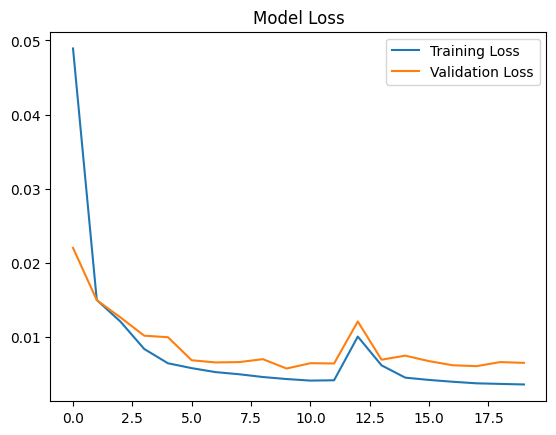

In [24]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_dev, y_dev),
    verbose=1
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [25]:
scaled_predictions = model.predict(X_test)

predictions = scaler.inverse_transform(scaled_predictions)

true_values = scaler.inverse_transform(y_test)

print(f"Predictions shape: {predictions.shape}") 
print(f"True values shape: {true_values.shape}") 

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Predictions shape: (1807, 24)
True values shape: (1807, 24)
Predictions shape: (1807, 24)
True values shape: (1807, 24)
